# <center>6. Beam Orientation Optimization (BOO) Benchmarking </center>

### This example demonstrates performing the following tasks using portpy:

1. Query the existing patients in the database
    (you first need to download the patient database from the link provided in the GitHub page).
2. Query the data provided for a specified patient in the database.
3. Create a simple IMRT plan using CVXPy package. You can call different opensource/commercial optimization engines
    from CVXPy,but you first need to download them and obtain an appropriate license.
    Most commercial optimization engines (e.g., Mosek, Gorubi) give free academic license if you have .edu email
    address
4. Use portpy_photon to create down sampled influence matrix and optimize the plan by selecting optimal beams using beam angle optimization
5. Visualise the plan (dvh, dose distribution)


In [1]:
# !pip install portpy-photon

In [1]:
import portpy_photon as pp
pp.__version__

'0.0.3'

In [2]:
# specify the patient data location
# (you first need to download the patient database from the link provided in the GitHub page)
data_dir = r'../data'
# display the existing patients. To display it in browser rather than console, turn on in_browser=True
pp.Visualize.display_patients(data_dir=data_dir)

F:\Research\Data_newformat\Python-PORT\examples


,patient_id,disease_site,ptv_vol_cc,num_beams,iso_center_shift
0,Lung_Patient_1,Lung,737.229,72,No


In [3]:
# pick a patient from the existing patient list to get detailed info about the patient data (e.g., beams_dict, structures, )
patient_id = 'Lung_Patient_1'
pp.Visualize.display_patient_metadata(patient_id, data_dir=data_dir)

Beams table..


,ID,gantry_angle,collimator_angle,couch_angle,beam_modality,energy_MV,influence_matrix(sparse/full),iso_center,MLC_name,machine_name
0,0,0,0,0,Photon,6,Both,"{'x_mm': -73.98, 'y_mm': 16.68178, 'z_mm': -18.52955}",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
1,1,5,0,0,Photon,6,Both,"{'x_mm': -73.98, 'y_mm': 16.68178, 'z_mm': -18.52955}",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
2,2,10,0,0,Photon,6,Both,"{'x_mm': -73.98, 'y_mm': 16.68178, 'z_mm': -18.52955}",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
3,3,15,0,0,Photon,6,Both,"{'x_mm': -73.98, 'y_mm': 16.68178, 'z_mm': -18.52955}",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
4,4,20,0,0,Photon,6,Both,"{'x_mm': -73.98, 'y_mm': 16.68178, 'z_mm': -18.52955}",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
5,5,25,0,0,Photon,6,Both,"{'x_mm': -73.98, 'y_mm': 16.68178, 'z_mm': -18.52955}",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
6,6,30,0,0,Photon,6,Both,"{'x_mm': -73.98, 'y_mm': 16.68178, 'z_mm': -18.52955}",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
7,7,35,0,0,Photon,6,Both,"{'x_mm': -73.98, 'y_mm': 16.68178, 'z_mm': -18.52955}",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
8,8,40,0,0,Photon,6,Both,"{'x_mm': -73.98, 'y_mm': 16.68178, 'z_mm': -18.52955}",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
9,9,45,0,0,Photon,6,Both,"{'x_mm': -73.98, 'y_mm': 16.68178, 'z_mm': -18.52955}",VARIAN MILLENIUM 120,VARIAN TRUE BEAM


,name,volume_cc
0,GTV,356.987366
1,PTV,737.229248
2,ESOPHAGUS,54.889477
3,HEART,1069.187000
4,LUNG_L,1969.533690
5,LUNG_R,1890.889890
6,CORD,63.291187
7,SKIN,1.000000


Structure table..


### Create plan
Create my_plan object for the planner beams.

For the customized beams_dict, you can pass the argument beam_ids
e.g. my_plan = pp.Plan(patient_name, beam_ids=[0,1,2,3,4,5,6])


In [5]:
# create my_plan object for the planner beams_dict
# for the customized beams_dict, you can pass the argument beam_ids
# e.g. my_plan = Plan(patient_name, beam_ids=[0,1,2,3,4,5,6], options=options)
# creating plan and select among the beams which are 30 degrees apart
# beam_ids = [0, 37, 42, 48, 54, 60, 66]
beam_ids = [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66]
plan_boo = pp.Plan(patient_id, data_dir=data_dir, beam_ids=beam_ids)

Creating BEV..
Loading sparse influence matrix...
Done


In [6]:
# create a influence matrix down sampled beamlets of width and height 5mm
down_sample_factor = [5, 5, 1]
opt_vox_xyz_res_mm = [ct_res * factor for ct_res, factor in zip(plan_boo.get_ct_res_xyz_mm(), down_sample_factor)]
beamlet_down_sample_factor = 2
beamlet_width_mm = plan_boo.inf_matrix.beamlet_width_mm * beamlet_down_sample_factor
beamlet_height_mm = plan_boo.inf_matrix.beamlet_height_mm * beamlet_down_sample_factor
inf_matrix_dbv = plan_boo.create_inf_matrix(beamlet_width_mm=beamlet_width_mm, beamlet_height_mm=beamlet_height_mm,
                                            opt_vox_xyz_res_mm=opt_vox_xyz_res_mm)

Creating BEV..
reindexing voxels...
Loading sparse influence matrix...
parsing influence matrix for beam 0
parsing influence matrix for beam 1
parsing influence matrix for beam 2
parsing influence matrix for beam 3
parsing influence matrix for beam 4
parsing influence matrix for beam 5
parsing influence matrix for beam 6
parsing influence matrix for beam 7
parsing influence matrix for beam 8
parsing influence matrix for beam 9
parsing influence matrix for beam 10
parsing influence matrix for beam 11
creating influence matrix for down sample voxels..
Done


### Run Optimization
- Run imrt fluence map optimization using cvxpy and one of the supported solvers and save the optimal solution in sol dictionary
- CVXPy supports several opensource (ECOS, OSQP, SCS) and commercial solvers (e.g., MOSEK, GUROBI, CPLEX)
- For optimization problems with non-linear objective and/or constraints, MOSEK often performs well
- For mixed integer programs, GUROBI/CPLEX are good choices
- If you have .edu email address, you can get free academic license for commercial solvers
- We recommend the commercial solver MOSEK as your solver for the problems in this example,
  however, if you don't have a license, you can try opensource/free solver SCS or ECOS
  see [cvxpy](https://www.cvxpy.org/tutorial/advanced/index.html) for more info about CVXPy solvers
- To set up mosek solver, you can get mosek license file using edu account and place the license file in directory C:\Users\username\mosek

#### Model Formulation

$
   \mbox{Minimize} \quad  w_o||A_{target}\mathbf{x}-pres||_{+} + w_u||A_{target}\mathbf{x}-pres||_{-} + w_{sm}(smoothness \space objective) + w_{oar}  ||A_{oar} \mathbf{x}||
$

$
\mbox{subject to}
$

$
\quad maximum(A_s\mathbf{x}) \leq {d_s}^{max}
$

$
\quad mean(A_s\mathbf{x}) \leq {d_s}^{mean}
$

$
\quad \mathbf{x}_b \leq \mathbf{y}_bM  \quad \forall b \in B
$

$
\quad \sum_{b \in B}\mathbf{y} \leq \mu
$

$
\quad \mathbf{x} \geq 0
$

$
\quad \mathbf{y}_b \in \{0,1\}
$

where $w_o$ (overdose weight) = 10000 , $w_u$ (underdose weight) = 100000, $w_{sm}$ (smoothing weight) = 1000, $w_{oar}$ (oar weight) = 10, $s$ = structure index, $pres$ = prescription dose, $\mathbf{x}$ is beamlet intensity, $\mathbf{y}_b$ is binary variable for selecting the beam, ${d_s}^{max}$ = maximum dose for structure s, ${d_s}^{mean}$ = mean dose for structure s, $A$ = influence matrix, $M$ (large number) = 1000, $\mu$ (# of beams selected) = 7.

Smoothness objective is the total quadratic variation in beamlet intensity in x and y direction. It is given by,

$
smoothness \space objective = w_r\sum_{b\in{B}}\sum_{i\in{I_b}}(\mathbf{x}_i - \mathbf{x}_{R_i})^2 + w_l\sum_{b\in{B}}\sum_{i\in{I_b}}(\mathbf{x}_i - \mathbf{x}_{L_i})^2
$

where $w_r$ = 0.6, $w_l$=0.4, $R_i$ and $L_i$ = right and lower neigbour of beamlet i, $b$ = beam number, $I_b$ = beamlet indices of beam $b$

In [7]:
sol_boo = pp.Optimize.run_IMRT_fluence_map_CVXPy_BOO_benchmark(plan_boo, inf_matrix=inf_matrix_dbv)

creating rinds of size [5, 5, 20, 30, 500] mm ..
rinds created!!
Objective Start
Objective done
Constraints Start
Constraints Done
Problem loaded
                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Feb 07 12:59:05 PM: Your problem has 28531 variables, 30 constraints, and 0 parameters.
(CVXPY) Feb 07 12:59:05 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 07 12:59:05 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 07 12:59:05 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 07

(CVXPY) Feb 07 05:35:24 PM:   Solution status : INTEGER_OPTIMAL
(CVXPY) Feb 07 05:35:25 PM:   Primal.  obj: 4.9516847217e+01    nrm: 2e+05    Viol.  con: 1e-09    var: 0e+00    cones: 0e+00    itg: 0e+00  
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Feb 07 05:35:26 PM: Problem status: optimal
(CVXPY) Feb 07 05:35:26 PM: Optimal value: 4.904e+01
(CVXPY) Feb 07 05:35:26 PM: Compilation took 4.010e+01 seconds
(CVXPY) Feb 07 05:35:26 PM: Solver (including time spent in interface) took 1.654e+04 seconds
optimal value with MOSEK:49.04200028350646
Elapsed time 16591.225563287735 seconds


In [12]:
# Comment/Uncomment these lines to save & load plan and optimal solutions
# plan_boo = pp.load_plan(plan_name='plan_boo', path=r'C:\temp')
# sol_boo = pp.load_optimal_sol('sol_boo', path=r'C:\temp')
# plan_planner = pp.load_plan(plan_name='plan_planner', path=r'C:\temp')
# sol_planner = pp.load_optimal_sol('sol_planner', path=r'C:\temp')
pp.save_plan(plan_boo, plan_name='plan_boo', path=r'C:\temp')
pp.save_optimal_sol(sol_boo, sol_name='sol_boo', path=r'C:\temp')

In [13]:
# Similarly, let's create plan for the planner's beams
plan_planner = pp.Plan(patient_id, data_dir=data_dir)
inf_matrix_planner_dbv = plan_planner.create_inf_matrix(beamlet_width_mm=beamlet_width_mm,
                                                        beamlet_height_mm=beamlet_height_mm,
                                                        opt_vox_xyz_res_mm=opt_vox_xyz_res_mm)
sol_planner = pp.Optimize.run_IMRT_fluence_map_CVXPy(plan_planner, inf_matrix=inf_matrix_planner_dbv)

Creating BEV..
Loading sparse influence matrix...
Done
Creating BEV..
reindexing voxels...
Loading sparse influence matrix...
parsing influence matrix for beam 0
parsing influence matrix for beam 1
parsing influence matrix for beam 2
parsing influence matrix for beam 3
parsing influence matrix for beam 4
parsing influence matrix for beam 5
parsing influence matrix for beam 6
creating influence matrix for down sample voxels..
Done
creating rinds of size [5, 5, 20, 30, 500] mm ..
rinds created!!
Objective Start
Objective done
Constraints Start
Constraints Done
Problem loaded
                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Feb 07 09:48:25 PM: Your problem has 26292 variables, 17 constraints, and 0 parameters.
(CVXPY) Feb 07 09:48:25 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 07 09:48:25 PM: (If you need to solve this problem multiple times, bu

(CVXPY) Feb 07 09:49:05 PM: 19  3.1e-07  6.5e-02  7.8e-10  1.00e+00   5.814607736e+01   5.814607080e+01   4.0e-08  16.27 
(CVXPY) Feb 07 09:49:06 PM: 20  2.8e-08  2.5e-01  2.0e-11  1.00e+00   5.795522996e+01   5.795522942e+01   3.6e-09  16.91 
(CVXPY) Feb 07 09:49:07 PM: 21  1.7e-08  1.7e-01  1.3e-11  1.00e+00   5.794692632e+01   5.794692595e+01   2.6e-09  17.78 
(CVXPY) Feb 07 09:49:07 PM: 22  1.0e-08  9.5e+00  5.4e-12  1.00e+00   5.794290738e+01   5.794290714e+01   1.5e-09  18.20 
(CVXPY) Feb 07 09:49:08 PM: 23  4.8e-09  3.3e+01  1.7e-12  1.00e+00   5.793607958e+01   5.793607946e+01   7.1e-10  18.59 
(CVXPY) Feb 07 09:49:08 PM: 24  1.5e-09  9.6e+01  2.4e-13  1.00e+00   5.793401154e+01   5.793401146e+01   2.2e-10  19.02 
(CVXPY) Feb 07 09:49:08 PM: Optimizer terminated. Time: 19.23   
(CVXPY) Feb 07 09:49:08 PM: 
(CVXPY) Feb 07 09:49:08 PM: 
(CVXPY) Feb 07 09:49:08 PM: Interior-point solution summary
(CVXPY) Feb 07 09:49:08 PM:   Problem status  : PRIMAL_AND_DUAL_FEASIBLE
(CVXPY) Feb 

In [14]:
plan_planner.save_plan(plan_name='plan_planner', path=r'C:\temp')
# plan_planner.save_optimal_sol(sol_planner, sol_name='sol_planner', path=r'C:\temp')
plan_planner.save_optimal_sol(sol_planner, sol_name='sol_planner', path=r'C:\temp')
# plan_planner = pp.load_plan(plan_name='plan_planner', path=r'C:\temp')
# sol_planner = pp.load_optimal_sol('sol_planner', path=r'C:\temp')

In [22]:
# Identifying bao and planner gantry angles
import numpy as np
bao_gantry_angles = (np.asarray(plan_boo.beams.beams_dict['gantry_angle']) + 1) * (sol_boo['optimal_beams'] > 0)
bao_gantry_angles = bao_gantry_angles[bao_gantry_angles > 0] - 1  # add and subtract 1 to check for 0 degree angle
print('BAO gantry angles: {}'.format(bao_gantry_angles))
planner_gantry_angles = plan_planner.beams.beams_dict['gantry_angle']
print('Planner gantry angles: {}'.format(planner_gantry_angles))

obj_value_diff_per = (57.93-49.04)/(49.04)*100
print('Objective value improvement {} %'.format(obj_value_diff_per))

BAO gantry angles: [ 30 150 180 240 270 300 330]
Planner gantry angles: [0, 185, 210, 240, 270, 300, 330]
Objective value improvement 18.128058727569332 %


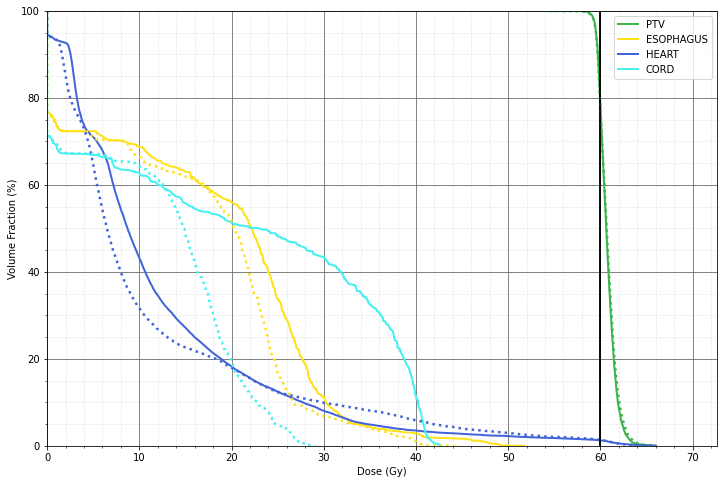

In [17]:
# plot dvh dvh for both the cases
structs = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD']

pp.Visualize.plot_dvh(plan_boo, sol=sol_boo, structs=structs, style='solid', show=False)
pp.Visualize.plot_dvh(plan_planner, sol=sol_planner, structs=structs, style='dotted', create_fig=False)


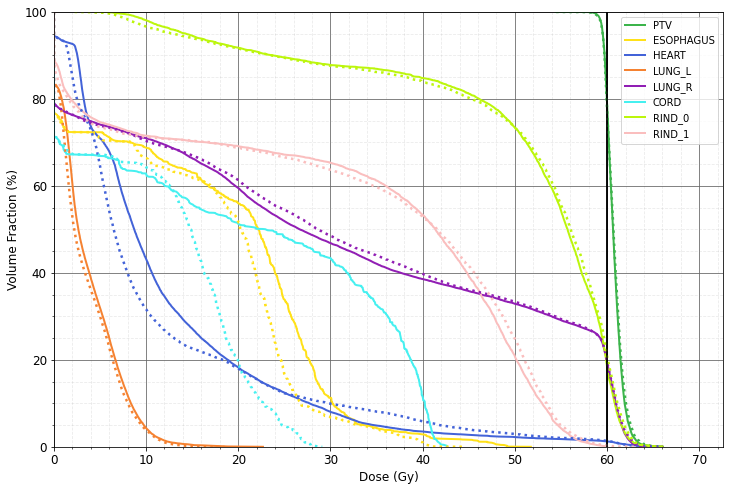

In [20]:
# plot dvh dvh for both the cases
structs = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD','LUNG_L','LUNG_R','RIND_0','RIND_1']

pp.Visualize.plot_dvh(plan_boo, sol=sol_boo, structs=structs, style='solid', show=False)
pp.Visualize.plot_dvh(plan_planner, sol=sol_planner, structs=structs, style='dotted', create_fig=False)


In [25]:
pp.save_optimal_sol(sol_boo, sol_name='sol_boo', path=r'C:\temp')
plan_planner.save_optimal_sol(sol_planner, sol_name='sol_planner', path=r'C:\temp')